In [1]:
pip install sciann

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 17.0 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/ianbgroves/PatternLearning

Cloning into 'PatternLearning'...
remote: Enumerating objects: 636, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 636 (delta 7), reused 9 (delta 3), pack-reused 612
Receiving objects: 100% (636/636), 525.75 MiB | 12.96 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Updating files: 100% (579/579), done.


In [3]:
import numpy as np
import sciann as sn
import matplotlib.pyplot as plt
import scipy.io
import os

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.12.0 
Python Version: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0] 



In [4]:

repoPath = os.path.join(".", "PINNs")
utilsPath = os.path.join(repoPath, "Utilities")
dataPath = os.path.join(repoPath, "main", "Data")
appDataPath = os.path.join(repoPath, "appendix", "Data")


# Introduction
This is the code for the Navier-Stokes inversion problem from SciANN paper:
+ https://arxiv.org/abs/2005.08803
+ https://www.sciencedirect.com/science/article/pii/S0045782520307374

The training data can be found in the following repository:
+ https://github.com/maziarraissi/PINNs/tree/master/main/Data/cylinder_nektar_wake.mat

In [5]:
def PrepareData(num_data=5000, random=True):

    # Get data file from:
    #         https://github.com/maziarraissi/PINNs/tree/master/main/Data/cylinder_nektar_wake.mat
    data = scipy.io.loadmat('/content/PatternLearning/PINNs/Raissi_2019_tensorflow2/main/Data/cylinder_nektar_wake.mat')

    U_star = data['U_star'] # N x 2 x T
    P_star = data['p_star'] # N x T
    t_star = data['t'] # T x 1
    X_star = data['X_star'] # N x 2

    N = X_star.shape[0]
    T = t_star.shape[0]

    # Rearrange Data
    XX = np.tile(X_star[:,0:1], (1,T)) # N x T
    YY = np.tile(X_star[:,1:2], (1,T)) # N x T
    TT = np.tile(t_star, (1,N)).T # N x T

    UU = U_star[:,0,:] # N x T
    VV = U_star[:,1,:] # N x T
    PP = P_star # N x T

    # Pick random data.
    if random:
        idx = np.random.choice(N*T, num_data, replace=False)
    else:
        idx = np.arange(0, N*T)

    x = XX.flatten()[idx,None] # NT x 1
    y = YY.flatten()[idx,None] # NT x 1
    t = TT.flatten()[idx,None] # NT x 1

    u = UU.flatten()[idx,None] # NT x 1
    v = VV.flatten()[idx,None] # NT x 1
    p = PP.flatten()[idx,None] # NT x 1

    return (x,y,t,u,v,p)

In [6]:
x_train, y_train, t_train, u_train, v_train, p_train = PrepareData(5000, random=True)

# PINN setup

As discussed in the paper, the independent variables are $(x,y,t)$ and the solution variables are $(p, \psi)$. The velocities are defined as $u=\psi_{,y}$ and $v=-\psi_{,x}$.

The neural networks are:
$$
p: (x,y,t) \rightarrow \mathcal{N}_p(x,y,t; \mathbf{W}, \mathbf{b})
\psi: (x,y,t) \rightarrow \mathcal{N}_{\psi}(x,y,t; \mathbf{W}, \mathbf{b})
$$


The governing relations are summerized as:
$$
u_{,t} + p_{,x} + \lambda_1 (u u_{,x} + v u_{,y}) - \lambda_2 (u_{,xx} + u_{,yy}) = 0 \\
v_{,t} + p_{,y} + \lambda_1 (u v_{,x} + v v_{,y}) - \lambda_2 (v_{,xx} + v_{,yy}) = 0
$$



Define independent variables with `sn.Variable`:

In [7]:
x = sn.Variable("x", dtype='float64')
y = sn.Variable("y", dtype='float64')
t = sn.Variable("t", dtype='float64')

Define solution variables with `sn.Functional` (multi-layer neural network):

In [8]:
P = sn.Functional("P", [x, y, t], 8*[20], 'tanh')
Psi = sn.Functional("Psi", [x, y, t], 8*[20], 'tanh')

For inversion, define parameters using `sn.Parameter`:

In [9]:
lambda1 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda1")
lambda2 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda2")

Use `sn.diff` and other mathematical operations to set up the PINN model.

In [10]:
u = sn.diff(Psi, y)
v = -sn.diff(Psi, x)

u_t = sn.diff(u, t)
u_x = sn.diff(u, x)
u_y = sn.diff(u, y)
u_xx = sn.diff(u, x, order=2)
u_yy = sn.diff(u, y, order=2)

v_t = sn.diff(v, t)
v_x = sn.diff(v, x)
v_y = sn.diff(v, y)
v_xx = sn.diff(v, x, order=2)
v_yy = sn.diff(v, y, order=2)

p_x = sn.diff(P, x)
p_y = sn.diff(P, y)

Define targets (losses) using `sn.Data`, `sn.Tie`, and `sn.PDE` interfaces.

In [11]:
# Define constraints
d1 = sn.Data(u)
d2 = sn.Data(v)
d3 = sn.Data(P)

c1 = sn.Tie(-p_x, u_t+lambda1*(u*u_x+v*u_y)-lambda2*(u_xx+u_yy))
c2 = sn.Tie(-p_y, v_t+lambda1*(u*v_x+v*v_y)-lambda2*(v_xx+v_yy))
c3 = sn.Data(u_x + v_y)

Keras <= 1.4.0 requires training on every target. Therefore, it will through an error if we do not train on $\psi$.

To resolve this error, let's add a trivial target for $\psi$:

In [12]:
c4 = Psi*0.0

Define the optimization model with `sn.SciModel`:

In [13]:
# Define the optimization model (set of inputs and constraints)
model = sn.SciModel(
    inputs=[x, y, t],
    targets=[d1, d2, d3, c1, c2, c3, c4],
    loss_func="mse",
    plot_to_file='NS-Model.png'
)

The network is plotted in the NS-Model.png file.

![SciModel](https://github.com/ianbgroves/sciann-applications/blob/master/SciANN-NavierStokes/NS-Model.png?raw=1)

Prepare the training data according to the order they are defined in `sn.SciModel`.

In [14]:
input_data = [x_train, y_train, t_train]

In [15]:
data_d1 = u_train
data_d2 = v_train
data_d3 = p_train
data_c1 = 'zeros'
data_c2 = 'zeros'
data_c3 = 'zeros'
data_c4 = 'zeros'
target_data = [data_d1, data_d2, data_d3, data_c1, data_c2, data_c3, data_c4]

Train the model by calling `.train` function. Check the documentation at www.sciann.com for all the training options.

In [16]:
from time import time
start = time()
history = model.train(
    x_true=input_data,
    y_true=target_data,
    epochs=500,
    batch_size=200,
    shuffle=True,
    learning_rate=0.001,
    reduce_lr_after=100,
    stop_loss_value=1e-8,
    verbose=1
)
print("time taken to train: {}s".format(time()-start))
model.save_weights('trained-navier-stokes.hdf5')


Total samples: 5000 
Batch size: 200 
Total batches: 25 

Epoch 1/500
25/25 [==============================] - 32s 57ms/step - batch: 12.0000 - size: 200.0000 - loss: 0.8039 - Grad__loss: 0.6796 - mul_loss: 0.0781 - P_loss: 0.0212 - sub_2_loss: 0.0162 - sub_4_loss: 0.0088 - add_7_loss: 1.2322e-34 - mul_12_loss: 0.0000e+00 - lr: 0.0010 - time: 31.6398
Epoch 2/500
25/25 [==============================] - 1s 46ms/step - batch: 12.0000 - size: 200.0000 - loss: 0.5109 - Grad__loss: 0.3388 - mul_loss: 0.0993 - P_loss: 0.0100 - sub_2_loss: 0.0361 - sub_4_loss: 0.0269 - add_7_loss: 8.6484e-34 - mul_12_loss: 0.0000e+00 - lr: 0.0010 - time: 1.1561
Epoch 3/500
25/25 [==============================] - 1s 47ms/step - batch: 12.0000 - size: 200.0000 - loss: 0.3906 - Grad__loss: 0.2371 - mul_loss: 0.0902 - P_loss: 0.0095 - sub_2_loss: 0.0312 - sub_4_loss: 0.0225 - add_7_loss: 9.7356e-34 - mul_12_loss: 0.0000e+00 - lr: 0.0010 - time: 1.1986
Epoch 4/500
25/25 [==============================] - 1s 53ms

In [17]:
print("lambda1: {},  lambda2: {}".format(lambda1.value, lambda2.value))

lambda1: [0.96483521],  lambda2: [0.01398482]


Text(0, 0.5, 'loss')

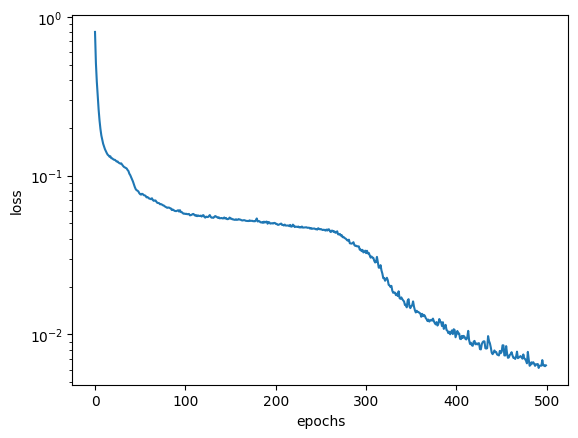

In [18]:
plt.semilogy(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')